In [1]:
!mdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

/bin/bash: line 1: mdir: command not found
cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download abdulvahap/music-instrunment-sounds-for-classification

Dataset URL: https://www.kaggle.com/datasets/abdulvahap/music-instrunment-sounds-for-classification
License(s): apache-2.0
100% 4.58G/4.59G [01:02<00:00, 106MB/s]
100% 4.59G/4.59G [01:02<00:00, 78.9MB/s]


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import glob
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [4]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPool2D, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

In [5]:
import zipfile
zip_ref = zipfile.ZipFile('music-instrunment-sounds-for-classification.zip', 'r')
zip_ref.extractall()
zip_ref.close()

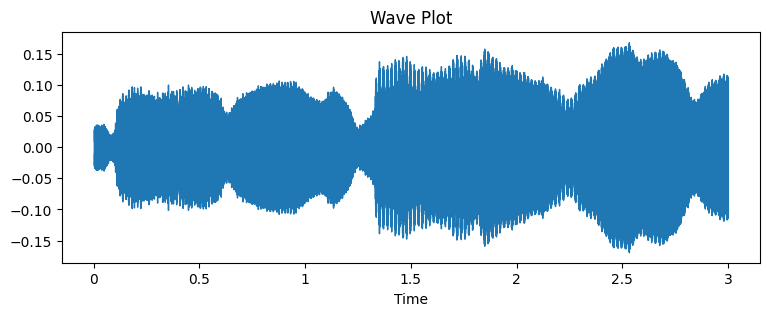

[ 0.00973511  0.01531982  0.01846313 ... -0.02261353 -0.00457764
  0.0145874 ]
22050


In [6]:
# Flute Sample for how we check wave of sound
filename = '/content/music_dataset/flute/10.wav'
plt.figure(figsize=(9,3))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
plt.title('Wave Plot')
plt.show()
print(data)
print(sample_rate)

In [7]:
from IPython.display import Audio

In [8]:
Audio(data=data, rate=sample_rate)

In [9]:
def plot_melspectrogram(y, sr):
  spectogram = librosa.feature.melspectrogram(y=data, sr=sample_rate)
  spectogram_db = librosa.power_to_db(spectogram, ref=np.max)
  plt.figure(figsize=(9,3))
  librosa.display.specshow(spectogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Mel Spectrogram')
  plt.tight_layout()
  plt.show()

In [10]:
print(sorted(os.listdir('/content/music_dataset')))

['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']


In [11]:
main_path = '/content/music_dataset'
label = ['Accordion', 'Acoustic_Guitar', 'Banjo', 'Bass_Guitar', 'Clarinet', 'Cymbals', 'Dobro', 'Drum_set', 'Electro_Guitar', 'Floor_Tom', 'Harmonica', 'Harmonium', 'Hi_Hats', 'Horn', 'Keyboard', 'Mandolin', 'Organ', 'Piano', 'Saxophone', 'Shakers', 'Tambourine', 'Trombone', 'Trumpet', 'Ukulele', 'Violin', 'cowbell', 'flute', 'vibraphone']

In [12]:
def extract_features(main_path, label):
  data = []
  labels = []
  for i_class, class_name in enumerate(label):
    path = os.path.join(main_path, class_name)
    print('preprocessing -- ',class_name)
    for file_name in os.listdir(path):
      if file_name.endswith('.wav'):
        file_path = os.path.join(path, file_name)
        audio_data, sample_rate = librosa.load(file_path, sr=None)

        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=80)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
        # Reshape for model input
        mfccs_scaled = mfccs_scaled.reshape(80, 1, 1)

        data.append(mfccs_scaled)
        labels.append(i_class)
  return np.array(data), np.array(labels)


In [13]:
data, labels = extract_features(main_path, label)

preprocessing --  Accordion
preprocessing --  Acoustic_Guitar
preprocessing --  Banjo
preprocessing --  Bass_Guitar
preprocessing --  Clarinet
preprocessing --  Cymbals
preprocessing --  Dobro
preprocessing --  Drum_set
preprocessing --  Electro_Guitar
preprocessing --  Floor_Tom
preprocessing --  Harmonica
preprocessing --  Harmonium
preprocessing --  Hi_Hats
preprocessing --  Horn
preprocessing --  Keyboard
preprocessing --  Mandolin
preprocessing --  Organ
preprocessing --  Piano
preprocessing --  Saxophone
preprocessing --  Shakers
preprocessing --  Tambourine
preprocessing --  Trombone
preprocessing --  Trumpet
preprocessing --  Ukulele
preprocessing --  Violin
preprocessing --  cowbell
preprocessing --  flute
preprocessing --  vibraphone


In [24]:
data.shape

(42311, 80, 1, 1)

In [ ]:
labels.shape

In [14]:
# convert label into one-hot-encoding
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes=len(label))
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [15]:
labels.shape

(42311, 28)

In [16]:
X,y = data, labels

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [18]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(80, 1, 1), kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Conv2D(filters=32, kernel_size=(3, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))

model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))

model.add(Conv2D(filters=128, kernel_size=(3, 1), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))

model.add(Conv2D(filters=256, kernel_size=(3, 1), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))

model.add(Conv2D(filters=512, kernel_size=(3, 1), activation='relu', padding='same', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1), strides=(2, 1)))


model.add(Flatten())
model.add(Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=len(label), activation='softmax'))


In [19]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 80, 1, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 80, 1, 32)           │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 80, 1, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 40, 1, 64)           │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 1, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 1, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 20, 1, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 1, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 1, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 1, 256)          │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 1, 512)           │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │              

 Total params: 1,230,876 (4.70 MB)

 Trainable params: 1,228,892 (4.69 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [20]:
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.5963 - loss: 8.3270 - val_accuracy: 0.8211 - val_loss: 1.7951
Epoch 2/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7981 - loss: 1.8409 - val_accuracy: 0.8486 - val_loss: 1.5200
Epoch 3/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8245 - loss: 1.6177 - val_accuracy: 0.8641 - val_loss: 1.4550
Epoch 4/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8421 - loss: 1.5239 - val_accuracy: 0.8647 - val_loss: 1.4337
Epoch 5/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8474 - loss: 1.4810 - val_accuracy: 0.8895 - val_loss: 1.2810
Epoch 6/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8587 - loss: 1.4003 - val_accuracy: 0.8596 - val_loss: 1.3379
Epoch 7/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8637 - loss: 1.3284 - val_accuracy: 0.8657 - val_loss: 1.2479
Epoch 8/10
1058/1058 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8704 - loss: 1.2633

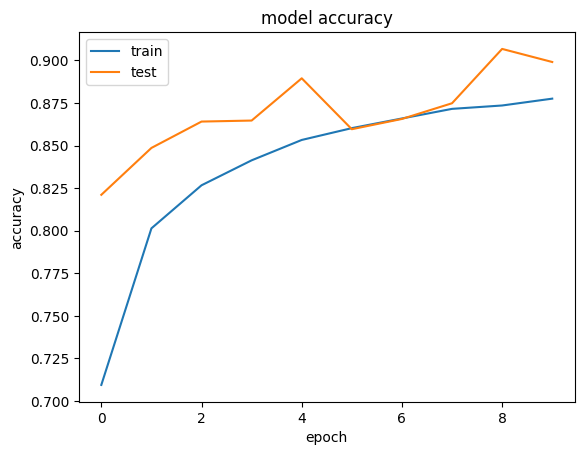

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

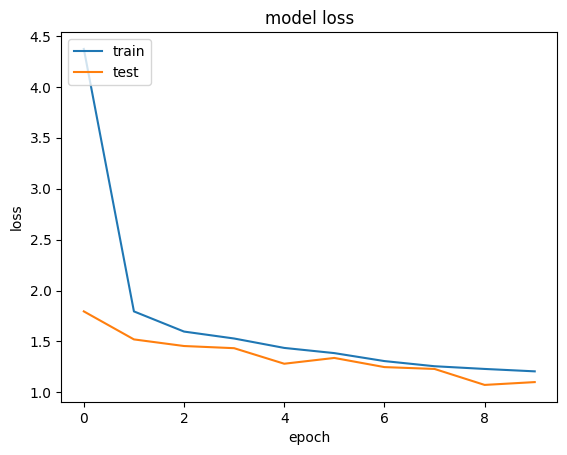

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
print('Final training accuracy: ', history.history['accuracy'][-1])
print('Final validation accuracy: ', history.history['val_accuracy'][-1])

Final training accuracy:  0.8775703310966492
Final validation accuracy:  0.8990901708602905


In [25]:

def predict_audio(file_path, model, label):
  audio_data, sample_rate = librosa.load(file_path, sr=None)
  mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=80)
  mfccs_scaled = np.mean(mfccs.T, axis=0)
  mfccs_scaled = mfccs_scaled.reshape(1, 80, 1, 1) # Reshape for model input (add batch dimension)
  prediction = model.predict(mfccs_scaled)
  predicted_class_index = np.argmax(prediction)
  predicted_label = label[predicted_class_index]
  return predicted_label, prediction


In [26]:
# Example usage (assuming 'model' and 'label' are defined from previous code):
file_path = '/content/music_dataset/Organ/1003.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
Predicted Label: Organ


In [27]:
file_path = '/content/ROOM_room6_MUS_pachelbel_DEV_amazon.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label: Piano


In [28]:
file_path = '/content/guitar-solo-74247.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Label: Mandolin


In [29]:
file_path = '/content/Va-ord-F4-ff-2c.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Label: Trumpet


In [30]:
file_path = '/content/rock-drum-loop-85371.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Label: Drum_set


In [31]:
file_path = '/content/Sad-Violin-Fast-E-www.fesliyanstudios.com.wav' # Replace with actual file path
predicted_label, probabilities = predict_audio(file_path, model, label)
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Label: Ukulele


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/Test_submission.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [32]:

def predict_audio_folder(folder_path, model, label):
  for filename in os.listdir(folder_path):
    if filename.endswith(('.wav', '.mp3')): # Adjust extensions if needed
      file_path = os.path.join(folder_path, filename)
      try:
        predicted_label, probabilities = predict_audio(file_path, model, label)
        print(f"File: {filename}, Predicted Label: {predicted_label}")
      except Exception as e:
        print(f"Error processing {filename}: {e}")


In [ ]:
# Example usage:
test_folder = '/content/Test_submission' # Replace with the actual path to your test folder
predict_audio_folder(test_folder, model, label)